In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [37]:
path = '/kaggle/working/data'
if not os.path.exists(path):
    os.mkdir(path)

transfor = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transfor)
testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transfor)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=False, num_workers=2)
# 이미지 평균 및 표준편차 계산
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0.0
for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples
    
mean /= nb_samples
std /= nb_samples

mean = mean.numpy().tolist()
std = std.numpy().tolist()

print(mean)
print(std)

Files already downloaded and verified
Files already downloaded and verified
[0.4913995563983917, 0.48215848207473755, 0.44653093814849854]
[0.20230084657669067, 0.19941289722919464, 0.20096157491207123]


In [38]:
# 데이터셋 증강

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


# CIFAR-10
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [39]:
# 데이터로더 정보를 출력하는 함수
def print_dataloader_info(dataloader, loader_name):
    print(f"\n{loader_name} 정보:")
    for batch_idx, (images, labels) in enumerate(dataloader):
        print(f"배치 인덱스: {batch_idx}")
        print(f"이미지 크기: {images.size()}")
        if isinstance(labels, torch.Tensor):
            print(f"라벨 크기: {labels.size()}")
            print(f'라벨의 데이터타입 : {labels[0].dtype}')
        else:
            print(f"라벨 크기: {len(labels)}")
            print(f'라벨의 데이터타입 : {type(labels[0])}')
        if batch_idx == 0:  # 첫 번째 배치 정보만 출력
            break

# train_loader 정보 출력
print_dataloader_info(trainloader, "Train Loader")

# test_loader 정보 출력
print_dataloader_info(testloader, "Test Loader")


Train Loader 정보:
배치 인덱스: 0
이미지 크기: torch.Size([64, 3, 32, 32])
라벨 크기: torch.Size([64])
라벨의 데이터타입 : torch.int64

Test Loader 정보:
배치 인덱스: 0
이미지 크기: torch.Size([64, 3, 32, 32])
라벨 크기: torch.Size([64])
라벨의 데이터타입 : torch.int64


In [40]:
class BasicBlock(nn.Module):
    expansion_factor = 1
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))

        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)

        x += self.residual(identity) # shortcut connection
        x = self.relu1(x)
        return x

In [41]:
class BottleNeck(nn.Module):
    expansion_factor=4
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv3 = nn.Sequential(nn.Conv2d(out_channels, out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False),
                                   nn.BatchNorm2d(out_channels * self.expansion_factor))

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion_factor))

        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x += self.residual(identity) # shortcut connection
        x = self.relu1(x)
        return x

In [42]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Resnet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block,128, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block,256, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block,512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512 * block.expansion_factor, num_classes)

        self._init_layer()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks -1) # [stride, 1, 1, ..., 1] 1은 num_block -1 개
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion_factor
        return nn.Sequential(*layers)

    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [43]:
class Model:
    def resnet18(self):
        return Resnet(BasicBlock, [2, 2, 2, 2])

    def resnet34(self):
        return Resnet(BasicBlock, [3, 4, 6, 3])

    def resnet50(self):
        return Resnet(BottleNeck, [3, 4, 6, 3])

    def resnet101(self):
        return Resnet(BottleNeck, [3, 4, 23, 3])

    def resnet152(self):
        return Resnet(BottleNeck, [3, 8, 36, 3])

In [44]:
!pip install torchsummary
from torchsummary import summary

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 디바이스로 이동
model = Model().resnet101()
model = model.to(device)

# 모델 요약 출력
summary(model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [46]:
# 모델을 CUDA로 이동
model.to(device)

def model_train(model, data_loader, criterion, optimizer, epoch):
    model.train()

    global epoch_step
    running_size, running_loss, correct = 0.0, 0.0, 0.0

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        pbar = tqdm(data_loader)
    else:
        pbar = data_loader

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_size += images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar.set_description('[Training] loss: ' +
                                f'{running_loss / running_size:.4f}, accuracy: ' +
                                f'{correct / running_size:.4f}')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()
        
    avg_accuracy = correct / running_size
    avg_loss = running_loss / running_size

    return avg_loss, avg_accuracy

def model_eval(model, data_loader, criterion, epoch):
    model.eval()
    with torch.no_grad():
        running_loss, correct = 0.0, 0.0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar = tqdm(data_loader)
        else:
            pbar = data_loader

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)

            correct += torch.sum(pred == labels).item()
            running_loss += criterion(outputs, labels).item() * images.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        return loss, accuracy

In [45]:
# CUDA 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
initial_learning_rate = 0.1
num_epochs = 164
epoch_step = 15

# Loss function, optimizer
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.0001)

# scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)

In [47]:
# 모델 학습 및 평가 코드
loss, accuracy = [], []
num_epochs = 164
epoch_step = 15

for epoch in range(num_epochs):
    train_loss, train_accuracy = model_train(model, trainloader, criterion, optimizer, epoch)
    test_loss, test_accuracy = model_eval(model, testloader, criterion, epoch)

    loss.append([train_loss, test_loss])
    accuracy.append([train_accuracy, test_accuracy])

    scheduler.step()  # 스케줄러 업데이트

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}, Training loss: " + 
              f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# 모델 상태 저장
model_save_path = '/kaggle/working/data/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

100%|██████████| 157/157 [00:04<00:00, 38.95it/s]

epoch 001, Training loss: 3.5782, Training accuracy: 0.1496
Test loss: 28.3208, Test accuracy: 0.1819



100%|██████████| 157/157 [00:03<00:00, 41.04it/s]

epoch 015, Training loss: 1.3937, Training accuracy: 0.4962
Test loss: 1.3370, Test accuracy: 0.5369



100%|██████████| 157/157 [00:03<00:00, 39.60it/s]

epoch 030, Training loss: 0.9822, Training accuracy: 0.6566
Test loss: 0.9054, Test accuracy: 0.6866



100%|██████████| 157/157 [00:03<00:00, 41.88it/s]

epoch 045, Training loss: 0.7327, Training accuracy: 0.7488
Test loss: 0.7409, Test accuracy: 0.7504



100%|██████████| 157/157 [00:03<00:00, 39.81it/s]

epoch 060, Training loss: 0.6323, Training accuracy: 0.7846
Test loss: 0.6634, Test accuracy: 0.7783



100%|██████████| 157/157 [00:03<00:00, 40.39it/s]

epoch 075, Training loss: 0.5762, Training accuracy: 0.8047
Test loss: 0.6868, Test accuracy: 0.7629



100%|██████████| 157/157 [00:04<00:00, 39.04it/s]

epoch 090, Training loss: 0.5471, Training accuracy: 0.8128
Test loss: 0.6938, Test accuracy: 0.7764



100%|██████████| 157/157 [00:03<00:00, 40.88it/s]

epoch 105, Training loss: 0.5290, Training accuracy: 0.8198
Test loss: 0.5575, Test accuracy: 0.8175



100%|██████████| 157/157 [00:03<00:00, 40.89it/s]

epoch 120, Training loss: 0.5109, Training accuracy: 0.8256
Test loss: 0.6546, Test accuracy: 0.7869



100%|██████████| 157/157 [00:03<00:00, 39.84it/s]

epoch 135, Training loss: 0.5016, Training accuracy: 0.8305
Test loss: 0.5366, Test accuracy: 0.8198



100%|██████████| 157/157 [00:03<00:00, 39.72it/s]

epoch 150, Training loss: 0.4929, Training accuracy: 0.8318
Test loss: 0.5869, Test accuracy: 0.8115


Model saved to /kaggle/working/data/model.pth


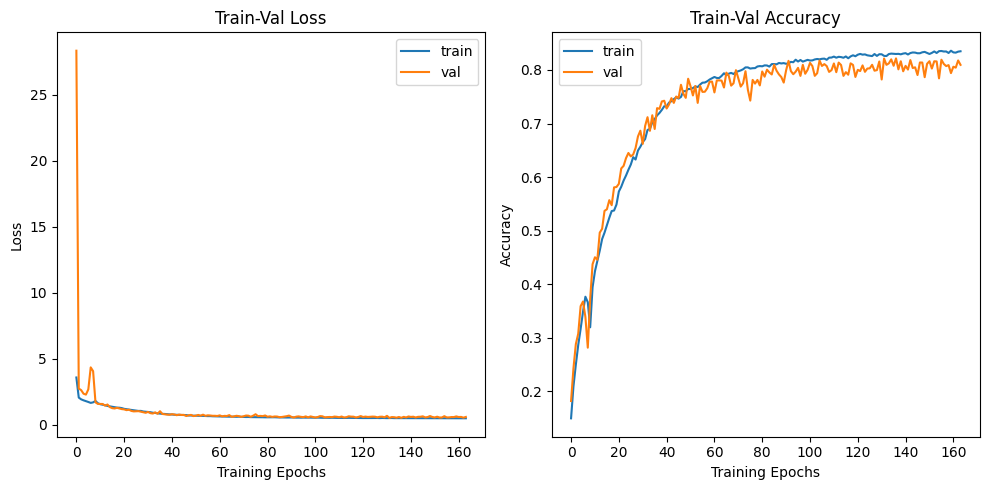

In [48]:
import matplotlib.pyplot as plt

# 손실 그래프
train_losses, val_losses = zip(*loss)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# 정확도 그래프
train_accuracies, val_accuracies = zip(*accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train-Val Accuracy')

plt.tight_layout()
plt.show()